## Bootstrap

This notebook introduces the suggested use of bootstrap to estimate the variance due to pathway and parameter uncertainty.

**Note** this notebook is very memory and computationally intensive. 

In [1]:
import driftmlp
import numpy as np
import matplotlib.pyplot as plt
import os
from cartopy import crs as ccrs

#Copy sample locations from basic_pathways page
from_loc = [-90.90, 23.88]
to_loc =[-9.88, 35.80] 
locs = {
    "Gulf of Mexico": from_loc,
    "Strait of Gibraltar": to_loc,
    "North Atlantic" : [-41, 34],
    "South Atlantic" : [-14, -27], 
    "North Pacific" : [-170, 30]
}
N_locs = len(locs)

### Make the network.

For the bootstrap we require more direct access to the data. The network loaded by `driftmlp.read_default_network` does not contain enough information about the original data to carry out bootstrapping. We actually need the original sequence of discrete indices. 

Therefore, we recreate the network below. The store_story stores a list of the discrete indices of the data. This is sufficient for bootstrapping.

In [2]:
DFILE = os.environ['DRIFTFILE']
%time T_mat = driftmlp.driftfile_to_network(DFILE, store_story=True)
%time T_mat_bootstrap = driftmlp.BootstrapNetwork(T_mat)

CPU times: user 5min 49s, sys: 4.4 s, total: 5min 53s
Wall time: 6min 10s
CPU times: user 32 s, sys: 144 ms, total: 32.2 s
Wall time: 32.2 s


Most of the computational time used is spent on discretizing the longitude, latitude pairs. Once these are read in the process is relatively quick. Luckily for the bootstrap we only need to discretize once. For this dataset on a modern laptop each bootstrap network can be formed in about 40 seconds.

What if we don't want the original transition matrix? We can save a bit of time by getting the stories. However this is a very minor speed up.

In [3]:
##Create the drifter generator then call it.
from driftmlp.drifter_indexing import driftiter,story
import numpy as np 
drift_gen = driftiter.generator(DFILE)()
drift_story = story.get_story(drift_gen)
boot_ids = np.random.randint(low=0, high=len(drift_story), size=len(drift_story), dtype=int).tolist()
boot_stories = [drift_story[i] for i in boot_ids]
%time boot_network2 = driftmlp.form_network.make_transition(boot_stories)
del boot_stories, boot_ids

CPU times: user 31.7 s, sys: 176 ms, total: 31.9 s
Wall time: 31.9 s


### Typical application of bootstrap

We'll simulate 10 bootstrap samples then do some basic exploratory results to get an idea of how variable the travel times are for the `locs` array.

Here we remove the Panama and Strait of Gibraltar connections. See the Rotations section for an example of what happens if this is not done.

In [4]:
N_BOOT = 10
# Generate networks, this is computationally hard bit.
boot_networks = [driftmlp.BootstrapNetwork(T_mat) for _ in range(N_BOOT)]

# Removes the Panama and Strait of Gibraltar artificial connections
for i in range(N_BOOT):
    driftmlp.helpers.remove_undesired(T_mat)
    
# Discretize the locations
h3_ids = driftmlp.DefaultSystem.return_inds(locs.values())
# Get all pathways
pairwise_boot_paths = [driftmlp.shortest_path.AllPairwisePaths(boot_T, h3_ids) for boot_T in boot_networks]

Below we'll look at the overall variance in the pathway. A darker line implies more uncertainty in the pathway

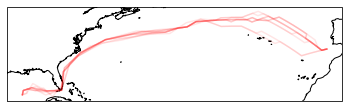

In [5]:
from driftmlp.plotting import h3_cartopy
gpd_df = driftmlp.plotting.make_gpd.full_multipolygon_df()
from_idx = 0
to_idx = 1
fig = plt.figure()
ax = plt.subplot(projection = ccrs.PlateCarree())

for i in range(N_BOOT):
    # Plot bootstrapped lines to show uncertainty in pathways.
    pathway = pairwise_boot_paths[i][from_idx][to_idx]
    h3_cartopy.plot_line(gpd_df, pathway.h3id, ax=ax, alpha=0.1, color='red', centroid_col='centroid_col')
ax.coastlines()

In [6]:
def extract_travel_time_matrix(list_of_lists):
    """
    Turn a list of lists of network paths into an array
    
    Prints a warning if there is an invalid path
    """
    tt = np.array([[path.travel_time for path in list_of_paths] for list_of_paths in list_of_lists])
    if np.any(tt<0):
        print("WARNING: There's an invalid path")
    return tt

travel_time_array = np.stack([extract_travel_time_matrix(bootstrap_paths) for bootstrap_paths in pairwise_boot_paths])

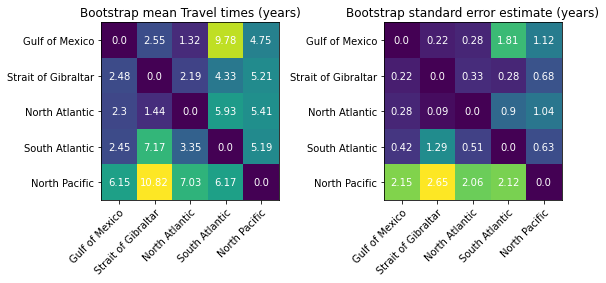

In [7]:
def make_heatmap(arr, ax):
    ax.set_xticks(np.arange(N_locs))
    ax.set_yticks(np.arange(N_locs))
    # ... and label them with the respective list entries
    ax.set_xticklabels(locs.keys())
    ax.set_yticklabels(locs.keys())
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(N_locs):
        for j in range(N_locs):
            text = ax.text(j, i, np.round(arr[i, j]/365,2) ,
                           ha="center", va="center", color="w")

    

    ax.imshow(arr)
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].set_title("Bootstrap mean Travel times (years)")
make_heatmap(travel_time_array.mean(axis=0), ax = ax[0])
ax[1].set_title("Bootstrap standard error estimate (years)")
make_heatmap(travel_time_array.std(axis=0, ddof=1), ax=ax[1])
fig.tight_layout()

The heatmap shows that generally lower travel times, come with lower uncertainty as we would expect. We could also compare the bootstrap mean to what we could get from the classic method:

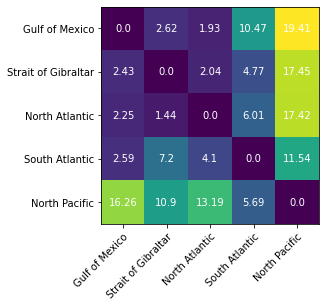

In [8]:
tt_classic = extract_travel_time_matrix(driftmlp.shortest_path.AllPairwisePaths(T_mat, h3_ids))
fig, ax = plt.subplots()
make_heatmap(tt_classic, ax)

The results above are likely subject to a high level of noise. Typically number of boostrap samples are much higher however this would take considerably longer to run. In practice setting N_Boot higher (say to N_BOOT=100) is advised!

In practice we also find that the bootstrap mean is a more robust method to use than the classic method. It averages over many different potential pathways; hence giving a less noisey estimate of the travel time. 

For a similar example estimating a different source of error look at the rotation example section of the documentation.